In [2]:
# importing the necessary libraries
from google.colab.patches import cv2_imshow
import cv2
import numpy as np
import os

### Preprocessing
In the preprocessing stage, our first step involves resizing the video frames to reduce computational complexity during the training of deep learning models. Next, to demonstrate the effectiveness of applying various filters such as Gaussian and Median filters for noise removal, we deliberately introduce salt and pepper noise to our frames. We then utilize the Median filter, well-known for its noise removal capabilities, to clean the frames from this type of noise. Afterward, for contrast enhancement, we apply CLAHE to our frames, carefully selecting appropriate clipping limits and grid sizes.

In [3]:
#Download Zip file containing sample video
!gdown --id 1sk8S3MqJp7srriWbio4q5N_3nPRG5k1i
# Unzip the zipped file
!unzip "/content/Files.zip" -d "/content/"
# Removing zipped file after getting the required folder in local directory
!rm /content/Files.zip
!mv '/content/pexels-cottonbro-5532773 (2160p).mp4' /content/sample.mp4



/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1sk8S3MqJp7srriWbio4q5N_3nPRG5k1i
To: /content/Files.zip
100% 25.5M/25.5M [00:00<00:00, 61.4MB/s]
Archive:  /content/Files.zip
  inflating: /content/pexels-cottonbro-5532773 (2160p).mp4  


###Functions for adding noise and performing contrast adjustement

In [4]:
def noise(image):
  # Salt Paper Noise
  row,col,ch = image.shape
  s_vs_p = np.random.rand()
  amount = np.random.rand()*0.001
  out = np.copy(image)
  # Salt mode
  num_salt = np.ceil(amount * image.size * s_vs_p)
  coords_x = np.random.randint(0,image.shape[0],int(num_salt))
  coords_y = np.random.randint(0,image.shape[1],int(num_salt))

  out[coords_x,coords_y,:] = np.random.randint(235,255)

  # Pepper mode
  num_pepper = np.ceil(amount* image.size * (1. - s_vs_p))
  coords_x = np.random.randint(0,image.shape[0],int(num_pepper))
  coords_y = np.random.randint(0,image.shape[1],int(num_pepper))

  out[coords_x,coords_y,:] = np.random.randint(0,20)
  return out

def CLAHE(img):

  lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)

  lab_planes = cv2.split(lab)
  lab_planes=np.array(lab_planes)
  lab_planes = lab_planes.astype(np.uint8)
#.......clipLimit Sets threshold for contrast limiting..........................
#.......tileGridSize defines the number of tiles in row and column..............
  clahe = cv2.createCLAHE(clipLimit=6.0,tileGridSize=(8,8))

  lab_planes[0] = clahe.apply(lab_planes[0])

  lab = cv2.merge(lab_planes)

  bgr = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)
  return bgr

def operations(frame):
   frame_res = cv2.resize(frame, (512, 256), fx = 0, fy = 0,
                         interpolation = cv2.INTER_CUBIC)
   # Adding noise to image
   noisy_img = noise(frame_res)
   # Applying median filter to noisy image
   median_img = cv2.medianBlur(noisy_img,5)
   # Applying CLAHE
   clahe_img = CLAHE(median_img)
   return clahe_img




###Demonstration

Original frame size:  (2160, 4096, 3)
New frame size:  (256, 512, 3)
Image after adding noise


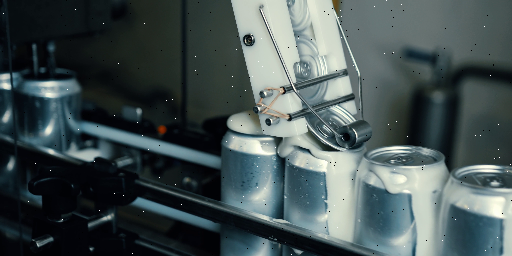

Image after applying median filter to remove added noise


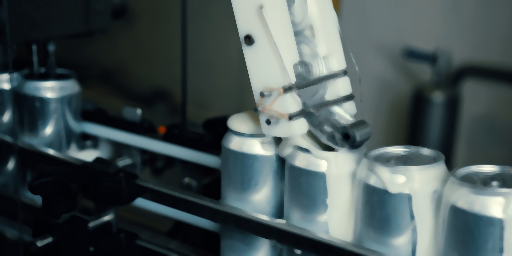

Image after applying CLAHE


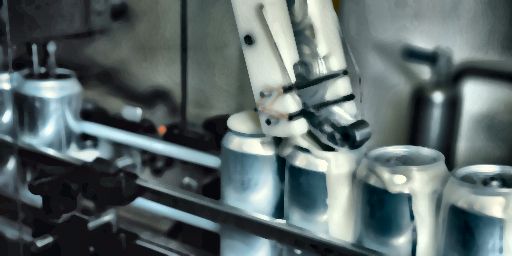

In [5]:
# Creating a VideoCapture object to read the video
resized_width = 256
resized_height = 512
cap = cv2.VideoCapture('/content/sample.mp4')

# Loop until the end of the video
while (cap.isOpened()):

    # Capture frame-by-frame\
    cap.set(cv2.CAP_PROP_POS_FRAMES, 200)
    ret, frame_orig = cap.read()
    # cv2_imshow(frame_orig)
    print("Original frame size: ",frame_orig.shape)
    frame_new = cv2.resize(frame_orig, (resized_height,resized_width), fx = 0, fy = 0,
                         interpolation = cv2.INTER_CUBIC)
    print("New frame size: ",frame_new.shape)
    # Generate random Gaussian noise
    noisy_img = noise(frame_new)
    print("Image after adding noise")
    cv2_imshow(noisy_img)
    median_img = cv2.medianBlur(frame_new,5)
    print("Image after applying median filter to remove added noise")
    cv2_imshow(median_img)
    clahe_img = CLAHE(median_img)
    print("Image after applying CLAHE")
    cv2_imshow(clahe_img)
    break

###Applying all the above operations on the whole video and saving it

In [7]:
cap = cv2.VideoCapture('/content/sample.mp4')
# Initialize video writer object
out = cv2.VideoWriter('output_video.mp4', cv2.VideoWriter_fourcc('M','J','P','G'), 20, (resized_height,resized_width))
print("Total number of frames: ",int(cap.get(cv2.CAP_PROP_FRAME_COUNT)))
while (cap.isOpened()):
  ret, frame = cap.read()
  if not ret:
    out.release()
    break
  frame_n = operations(frame.copy())
  out.write(frame_n)
# Release the objects
cap.release()
out.release()
print("--------Video saved-------------")


Total number of frames:  337
--------Video saved-------------


##Classification model

<table>
<tr>
    <th>Input image </th>
    <th>Label </th>
    </tr>
    <tr>
    <td> hand present </td>
    <td> 1 </td>
    </tr>
    <tr>
    <td> hand not present </td>
    <td> 0 </td>

</table>



At the time of inference, input to classification model will be the cropped ROI-1 and ROI-2. Then depending on the model's predictions, we will buzz an alarm or turn off the machine.






### Code snippet demonstrating the process of importing and defining a pre-trained classification model and unfolding its last fully connected layer according to the number of classes in our custom dataset.

In [1]:
import torch
from torch.nn import Linear
import torchvision
from torchvision.models import resnet18

# Model
model = resnet18(pretrained=True)

# Replace Output of Fully Connected Layer with Number of Labels for our Classification Problem
model.fc = Linear(in_features=512, out_features=2)
model

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 89.7MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

##Object detection model
I have already fine-tuned a pre-trained YOLOv8 model from Ultralytics for a custom dataset as part of an academic project. As such, I am providing the link to the Google Colab notebook for reference. However, I regret that I cannot grant access to the dataset due to the confidentiality of the IIT Bombay project work.


Link --> https://colab.research.google.com/drive/1-Sd_L5mT6nALyoLG0_xd84mMjD50yF16?usp=sharing